找到 3 個 xlsx 檔案

處理: E:\EarthScienceFair_Data\5\G1\5-G1-1.xlsx
  組別: 5-G1, 質量: 7.0871 kg
  [俯瞰 A] xaa / yaa


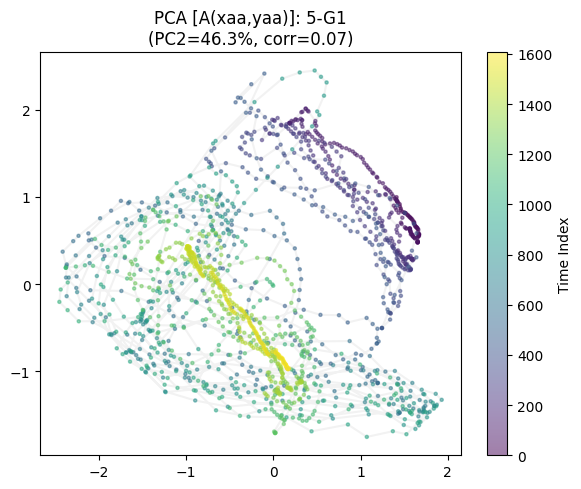

  [俯瞰 B] xab / yab


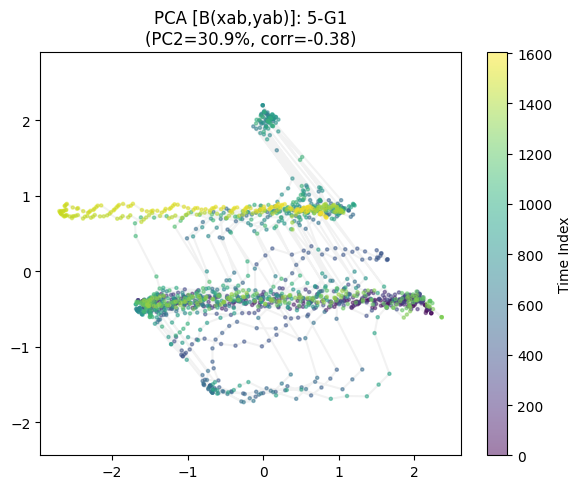

    發現 1/470 個空白值，進行插值...
    發現 1/470 個空白值，進行插值...
    ya 主頻率: 2.53 Hz
    yb 主頻率: 2.44 Hz
    yc 主頻率: 2.34 Hz
    yd 主頻率: 2.22 Hz
    ye 主頻率: 2.14 Hz
    yf 主頻率: 2.13 Hz
    yg 主頻率: 2.12 Hz
    yh 主頻率: 2.13 Hz
    yi 主頻率: 2.13 Hz
    yj 主頻率: 2.12 Hz
  側面系統自然頻率: 2.23 Hz
  ✓ 已處理 5-G1

處理: E:\EarthScienceFair_Data\5\G1\5-G1-2.xlsx
  組別: 5-G1, 質量: 7.0871 kg
  [俯瞰 A] xaa / yaa


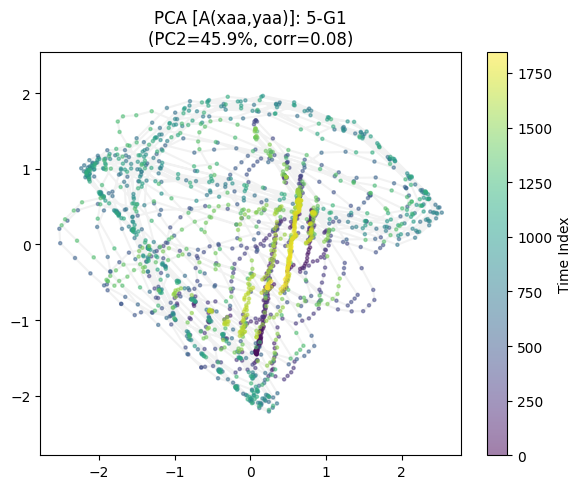

  [俯瞰 B] xab / yab


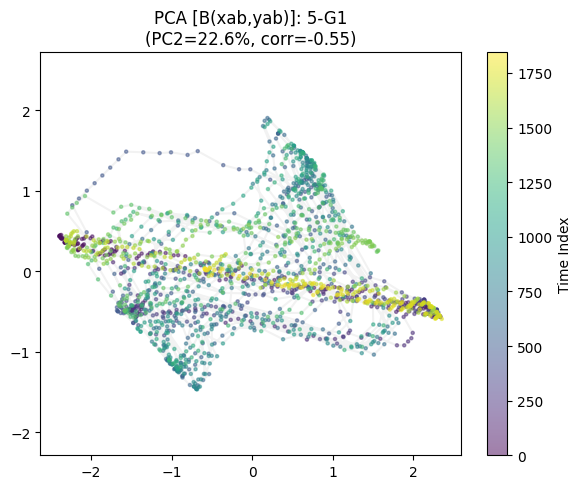

    ya 主頻率: 2.56 Hz
    yb 主頻率: 2.47 Hz
    yc 主頻率: 2.35 Hz
    yd 主頻率: 2.24 Hz
    ye 主頻率: 2.14 Hz
    yf 主頻率: 2.13 Hz
    yg 主頻率: 2.12 Hz
    yh 主頻率: 2.14 Hz
    yi 主頻率: 2.14 Hz
    yj 主頻率: 2.13 Hz
  側面系統自然頻率: 2.24 Hz
  ✓ 已處理 5-G1

處理: E:\EarthScienceFair_Data\5\G1\5-G1-3.xlsx
  組別: 5-G1, 質量: 7.0871 kg
  [俯瞰 A] xaa / yaa


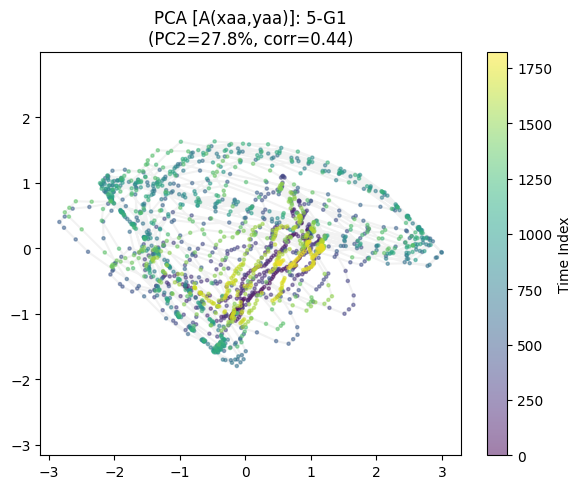

  [俯瞰 B] xab / yab


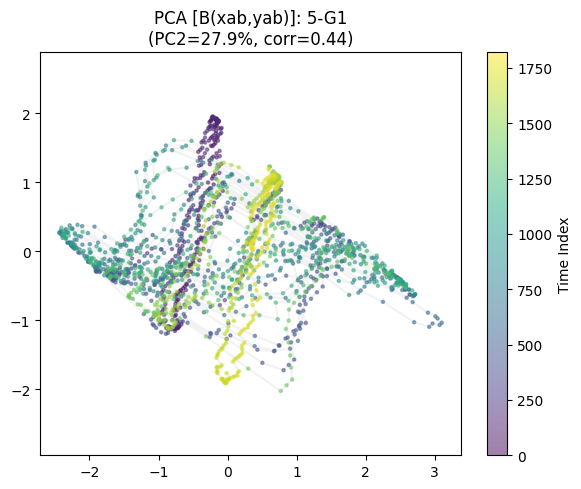

    發現 1/533 個空白值，進行插值...
    ya 主頻率: 2.56 Hz
    yb 主頻率: 2.48 Hz
    yc 主頻率: 2.37 Hz
    yd 主頻率: 2.25 Hz
    ye 主頻率: 2.17 Hz
    yf 主頻率: 2.16 Hz
    yg 主頻率: 2.16 Hz
    yh 主頻率: 2.17 Hz
    yi 主頻率: 2.16 Hz
    yj 主頻率: 2.16 Hz
  側面系統自然頻率: 2.26 Hz
  ✓ 已處理 5-G1


計算 5-G1 的不確定度:
  rms_x: 均值=0.0431, u=0.0058, 相對不確定度=13.37% (n=3)
  rms_y: 均值=0.0021, u=0.0004, 相對不確定度=20.12% (n=3)
  ratio: 均值=0.0563, u=0.0207, 相對不確定度=36.70% (n=3)
  f_n: 均值=2.2440, u=0.0097, 相對不確定度=0.43% (n=3)
  k: 均值=1408.9290, u=12.2284, 相對不確定度=0.87% (n=3)
  fa1: 均值=2.2233, u=0.0635, 相對不確定度=2.86% (n=3)
  fa2: 均值=2.2341, u=0.0920, 相對不確定度=4.12% (n=3)
  fb1: 均值=2.5144, u=0.0531, 相對不確定度=2.11% (n=3)
  fb2: 均值=2.5140, u=0.0547, 相對不確定度=2.18% (n=3)
  rms_acc: 均值=1.0122, u=0.0618, 相對不確定度=6.11% (n=3)

分析結果彙總:
                                     File Group    RMS_x    RMS_y     偏心比例  側面主頻率(Hz)  側面等效剛性(N/m)  俯瞰A_PC1頻率(Hz)  俯瞰A_PC2頻率(Hz)  俯瞰B_PC1頻率(Hz)  俯瞰B_PC2頻率(Hz)   RMS加速度
E:\EarthScienceFair_Data\5\G1\5-G1-1.xlsx  5-G1 0.054614 0.002

In [3]:
import os
import glob
import pandas as pd
import numpy as np
import zipfile
from scipy.fft import fft, fftfreq
from scipy.signal import medfilt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# ============================================================
# 路徑與實驗設定
# ============================================================
base_path = r"E:\EarthScienceFair_Data"
target_folders = ["5"]  # 只處理 file 5

# 各組質量 (kg)
mass_dict = {
    "5-G1": 7.0871,
    "5-G2": 6.6211,
    "5-G3": 6.1662,
    "5-G4": 6.1870,
    "5-G5": 6.2768,
    "5-G6": 6.2560,
    "5-G7": 6.2079,
}
default_mass = 6.2000

group_data = {}
results = []


# ============================================================
# 工具函式
# ============================================================

def filter_outliers(data, threshold=0.1):
    """標記與前一點差距超過 threshold 的異常值，回傳 bool 遮罩"""
    if len(data) <= 1:
        return np.ones(len(data), dtype=bool)
    valid_mask = np.ones(len(data), dtype=bool)
    for i in range(1, len(data)):
        if abs(data[i] - data[i-1]) > threshold:
            valid_mask[i] = False
    return valid_mask


def clean_side_data(side_data_raw, t_s_raw):
    """
    清理側面數據：
      - 以 t_s 有效列為基準對齊
      - 插值補空值
      - 過濾異常值後去中心化
    """
    time_series = pd.Series(t_s_raw)
    time_numeric = pd.to_numeric(time_series, errors='coerce')
    valid_time_mask = time_numeric.notna()

    data_series = pd.Series(side_data_raw)
    numeric_series = pd.to_numeric(data_series, errors='coerce')
    aligned_series = numeric_series[valid_time_mask]

    if aligned_series.isna().any():
        nan_count = aligned_series.isna().sum()
        total_count = len(aligned_series)
        print(f"    發現 {nan_count}/{total_count} 個空白值，進行插值...")
        aligned_series = aligned_series.interpolate(method='linear', limit_direction='both')
        aligned_series = aligned_series.ffill().bfill()

    data_clean = aligned_series[aligned_series.notna()].values
    if len(data_clean) == 0:
        return np.array([])

    data_clean = data_clean.astype(float)
    valid_mask = filter_outliers(data_clean, threshold=0.1)
    data_filtered = data_clean[valid_mask]

    if len(data_filtered) > 0:
        data_filtered = data_filtered - np.mean(data_filtered)

    return data_filtered


def clean_data_with_outlier_filter(data, time_data=False, allow_interpolation=True):
    """
    通用清理函式：
      - time_data=True  → 插值補齊後從 0 起算
      - time_data=False → 過濾異常值 → 插值 → 去中心化
    """
    s = pd.to_numeric(pd.Series(data), errors='coerce')

    if time_data:
        s = s.interpolate().ffill().bfill()
        val = s.values
        return val - val[0] if len(val) > 0 else np.array([])

    valid_mask = filter_outliers(s.values, threshold=0.1)
    s[~valid_mask] = np.nan

    if allow_interpolation:
        s = s.interpolate(method='linear', limit_direction='both').ffill().bfill()

    val = s.values
    if len(val) > 0:
        val = val - np.nanmean(val)
    return val


def auto_trim_index(y_signal, skip_seconds=3, dt=None, fps=30):
    """
    自動偵測訊號開始移動的時間點（排除前幾秒靜止段）
    若無法判斷則直接回傳 0
    """
    skip_frames = int(skip_seconds * fps) if dt is None else int(skip_seconds / dt)
    skip_frames = min(skip_frames, len(y_signal) - 1)
    return skip_frames


def process_overhead_pair(x_raw, y_raw, t_a, mass, label, combined_key):
    """
    處理一組俯瞰數據 (x, y)：
      - 中位數濾波 + 自動裁切
      - PCA 分析（繪圖）
      - FFT 頻率分析
      - RMS 計算
    回傳 dict: {rms_x, rms_y, ratio, f1, f2, k1, k2, var1, var2, corr}
    """
    nan_result = {k: np.nan for k in ['rms_x', 'rms_y', 'ratio', 'f1', 'f2', 'k1', 'k2',
                                       'var1', 'var2', 'corr']}

    x_clean = clean_data_with_outlier_filter(x_raw, allow_interpolation=False)
    y_clean = clean_data_with_outlier_filter(y_raw, allow_interpolation=False)

    if len(y_clean) == 0:
        return nan_result, 0

    x_med = medfilt(x_clean, kernel_size=5)
    y_med = medfilt(y_clean, kernel_size=5)

    # 估算 fps（由 t_a 推算）
    dt_arr = np.diff(t_a)
    dt_mean = np.mean(dt_arr[dt_arr > 0]) if np.any(dt_arr > 0) else 1/30
    start_idx = auto_trim_index(y_med, skip_seconds=3, dt=dt_mean)

    x = x_med[start_idx:]
    y = y_med[start_idx:]

    # --- PCA ---
    df_pca = pd.DataFrame({'x': x, 'y': y}).dropna()
    if len(df_pca) <= 10:
        return nan_result, start_idx

    scaler = StandardScaler()
    pca_input_scaled = scaler.fit_transform(df_pca.values)
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(pca_input_scaled)

    var1, var2 = pca.explained_variance_ratio_
    from scipy.stats import pearsonr
    corr, _ = pearsonr(df_pca['x'], df_pca['y'])

    # 繪製 PCA 圖
    plt.figure(figsize=(6, 5))
    sc = plt.scatter(pca_result[:, 0], pca_result[:, 1],
                     c=np.arange(len(pca_result)), cmap='viridis', s=5, alpha=0.5)
    plt.plot(pca_result[:, 0], pca_result[:, 1], alpha=0.1, color='gray')
    plt.axis('equal')
    plt.title(f"PCA [{label}]: {combined_key}\n(PC2={var2:.1%}, corr={corr:.2f})")
    plt.colorbar(sc, label='Time Index')
    plt.tight_layout()
    plt.show()

    # --- FFT 頻率分析 ---
    dt = np.mean(np.diff(t_a[:len(pca_result)])) if len(t_a) >= len(pca_result) else dt_mean
    f_list, k_list = [], []

    for i in range(2):
        pc_sig = pca_result[:, i] - np.mean(pca_result[:, i])
        N = len(pc_sig)
        yf_fft = fft(pc_sig)
        xf = fftfreq(N, dt)[:N//2]
        amp = 2.0/N * np.abs(yf_fft[:N//2])

        mask = (xf >= 1.2) & (xf <= 5.0)
        if np.any(mask):
            f_mode = np.sum(xf[mask] * amp[mask]) / np.sum(amp[mask])
            k_mode = mass * (2 * np.pi * f_mode)**2
            f_list.append(f_mode)
            k_list.append(k_mode)
        else:
            f_list.append(np.nan)
            k_list.append(np.nan)

    # --- RMS ---
    rms_x = np.sqrt(np.mean((x - np.mean(x))**2)) if len(x) > 0 else np.nan
    rms_y = np.sqrt(np.mean((y - np.mean(y))**2)) if len(y) > 0 else np.nan
    ratio  = rms_y / rms_x if (rms_x and rms_x != 0) else np.nan

    return {
        'rms_x': rms_x, 'rms_y': rms_y, 'ratio': ratio,
        'f1': f_list[0], 'f2': f_list[1],
        'k1': k_list[0], 'k2': k_list[1],
        'var1': var1,    'var2': var2,    'corr': corr
    }, start_idx


# ============================================================
# 主流程
# ============================================================

# 搜尋所有 xlsx
xlsx_files = []
for folder in target_folders:
    folder_path = os.path.join(base_path, folder)
    if os.path.exists(folder_path):
        xlsx_files.extend(glob.glob(os.path.join(folder_path, "**", "*.xlsx"), recursive=True))

print(f"找到 {len(xlsx_files)} 個 xlsx 檔案\n")

for tracker_file in xlsx_files:
    print("處理:", tracker_file)

    # 提取組別
    file_name = os.path.basename(tracker_file)
    parts = file_name.split('-')
    if len(parts) >= 2:
        folder_num = parts[0]
        group_name = parts[1]
        combined_key = f"{folder_num}-{group_name}"
    else:
        print("  檔名格式不符，跳過")
        continue

    mass = mass_dict.get(combined_key, default_mass)
    print(f"  組別: {combined_key}, 質量: {mass} kg")

    try:
        df = pd.read_excel(tracker_file)
    except Exception as e:
        print(f"  讀取失敗: {e}")
        continue

    # ── 讀取欄位 ──────────────────────────────────────────
    # 側面（前 8 欄）
    t_s_raw  = df.iloc[:, 0].values   # 側面時間
    ya_raw   = df.iloc[:, 1].values
    yb_raw   = df.iloc[:, 2].values
    yc_raw   = df.iloc[:, 3].values
    yd_raw   = df.iloc[:, 4].values
    ye_raw   = df.iloc[:, 5].values
    yf_raw   = df.iloc[:, 6].values
    yg_raw   = df.iloc[:, 7].values

    # 側面（倒數 9~7 欄）
    yh_raw   = df.iloc[:, -9].values
    yi_raw   = df.iloc[:, -8].values
    yj_raw   = df.iloc[:, -7].values

    # 俯瞰（倒數 5~1 欄）
    t_a_raw  = df.iloc[:, -5].values   # 俯瞰時間
    xaa_raw  = df.iloc[:, -4].values
    yaa_raw  = df.iloc[:, -3].values
    xab_raw  = df.iloc[:, -2].values
    yab_raw  = df.iloc[:, -1].values

    # ── 1. 清理時間序列 ───────────────────────────────────
    t_s = clean_data_with_outlier_filter(t_s_raw, time_data=True, allow_interpolation=False)
    t_a = clean_data_with_outlier_filter(t_a_raw, time_data=True, allow_interpolation=False)

    # ── 2. 俯瞰組 A (xaa, yaa) ────────────────────────────
    print("  [俯瞰 A] xaa / yaa")
    res_a, start_idx_a = process_overhead_pair(
        xaa_raw, yaa_raw, t_a, mass, label="A(xaa,yaa)", combined_key=combined_key
    )

    # ── 3. 俯瞰組 B (xab, yab) ────────────────────────────
    print("  [俯瞰 B] xab / yab")
    res_b, start_idx_b = process_overhead_pair(
        xab_raw, yab_raw, t_a, mass, label="B(xab,yab)", combined_key=combined_key
    )

    # 取兩組俯瞰平均（或視需求改成各自記錄）
    rms_x  = np.nanmean([res_a['rms_x'], res_b['rms_x']])
    rms_y  = np.nanmean([res_a['rms_y'], res_b['rms_y']])
    ratio  = np.nanmean([res_a['ratio'],  res_b['ratio']])

    # ── 4. 側面數據：ya~yg + yh~yj 共 10 個測量點 ─────────
    # 使用 start_idx_a 作為同步裁切點（可改為 start_idx_b 或兩者取平均）
    side_raw_dict = {
        "ya": ya_raw, "yb": yb_raw, "yc": yc_raw,
        "yd": yd_raw, "ye": ye_raw, "yf": yf_raw,
        "yg": yg_raw, "yh": yh_raw, "yi": yi_raw, "yj": yj_raw
    }
    layers = {}

    for key, raw_val in side_raw_dict.items():
        side_clean = clean_side_data(raw_val, t_s_raw)
        if len(side_clean) > 0:
            side_med = medfilt(side_clean, kernel_size=5)
            # 與俯瞰數據同步裁切
            layers[key] = side_med[start_idx_a:] if len(side_med) > start_idx_a else side_med
        else:
            layers[key] = np.array([])

    # FFT 頻率分析（側面 10 點）
    main_freqs = []
    for key, y_layer in layers.items():
        if len(y_layer) < 10 or len(t_s) < 10:
            continue

        y_centered = y_layer - np.mean(y_layer)
        dt = np.mean(np.diff(t_s[:len(y_centered)]))
        if dt <= 0:
            continue

        N = len(y_centered)
        yf_fft = fft(y_centered)
        xf     = fftfreq(N, dt)[:N//2]
        amplitude = 2.0/N * np.abs(yf_fft[:N//2])

        mask = (xf >= 1.2) & (xf <= 5.0)
        if np.any(mask):
            main_freq = np.sum(xf[mask] * amplitude[mask]) / np.sum(amplitude[mask])
            print(f"    {key} 主頻率: {main_freq:.2f} Hz")
            main_freqs.append(main_freq)

    if len(main_freqs) > 0:
        f_n = np.mean(main_freqs)
        print(f"  側面系統自然頻率: {f_n:.2f} Hz")
    else:
        f_n = np.nan
        print("  側面無法計算頻率")

    k = mass * (2 * np.pi * f_n)**2 if not np.isnan(f_n) else np.nan

    # ── 5. 加速度 (ZIP → CSV) ─────────────────────────────
    folder_dir = os.path.dirname(tracker_file)
    base_name  = os.path.splitext(os.path.basename(tracker_file))[0]
    all_zips   = glob.glob(os.path.join(folder_dir, "*.zip"))
    zip_file   = next((z for z in all_zips if
                       os.path.splitext(os.path.basename(z))[0] == base_name), None)

    rms_acc = np.nan
    if zip_file:
        try:
            with zipfile.ZipFile(zip_file, 'r') as z:
                csv_files = [f for f in z.namelist() if f.endswith('.csv')]
                if csv_files:
                    with z.open(csv_files[0]) as f:
                        acc_df = pd.read_csv(f)
                        acc_abs_raw = acc_df.iloc[:, -1].values
                        acc_series  = pd.to_numeric(pd.Series(acc_abs_raw),
                                                    errors='coerce').dropna().values
                        if len(acc_series) > 0:
                            acc_filtered = acc_series[filter_outliers(acc_series, threshold=0.1)]
                            rms_acc = (np.sqrt(np.mean(acc_filtered**2))
                                       if len(acc_filtered) > 0 else np.nan)
        except Exception as e:
            print(f"  讀取 zip 錯誤: {e}")

    # ── 6. 儲存結果 ───────────────────────────────────────
    results.append([
        tracker_file, combined_key,
        rms_x, rms_y, ratio,
        f_n, k,
        res_a['f1'], res_a['f2'],      # 俯瞰 A 的 PC1/PC2 頻率
        res_b['f1'], res_b['f2'],      # 俯瞰 B 的 PC1/PC2 頻率
        rms_acc
    ])

    if combined_key not in group_data:
        group_data[combined_key] = {p: [] for p in
            ['rms_x', 'rms_y', 'ratio', 'f_n', 'k',
             'fa1', 'fa2', 'fb1', 'fb2', 'rms_acc']}

    for field, val in zip(
        ['rms_x', 'rms_y', 'ratio', 'f_n', 'k', 'fa1', 'fa2', 'fb1', 'fb2', 'rms_acc'],
        [rms_x,  rms_y,  ratio,  f_n,  k,
         res_a['f1'], res_a['f2'], res_b['f1'], res_b['f2'], rms_acc]
    ):
        group_data[combined_key][field].append(val)

    print(f"  ✓ 已處理 {combined_key}\n")


# ============================================================
# 結果彙整
# ============================================================

results_df = pd.DataFrame(results, columns=[
    "File", "Group",
    "RMS_x", "RMS_y", "偏心比例",
    "側面主頻率(Hz)", "側面等效剛性(N/m)",
    "俯瞰A_PC1頻率(Hz)", "俯瞰A_PC2頻率(Hz)",
    "俯瞰B_PC1頻率(Hz)", "俯瞰B_PC2頻率(Hz)",
    "RMS加速度"
])

# 不確定度計算
uncertainty_results = []

for grp_name, data in group_data.items():
    print(f"\n計算 {grp_name} 的不確定度:")
    uncertainties = {}

    for param_name, values in data.items():
        valid_values = [v for v in values if not np.isnan(v)]
        n = len(valid_values)

        if n >= 2:
            mean_val = np.mean(valid_values)
            std_val  = np.std(valid_values, ddof=1)
            u_val    = std_val / np.sqrt(n)
            rel_u    = (u_val / mean_val * 100) if mean_val != 0 else np.nan

            uncertainties[param_name] = {'mean': mean_val, 'std': std_val,
                                          'u': u_val, 'relative_u': rel_u, 'n': n}
            print(f"  {param_name}: 均值={mean_val:.4f}, u={u_val:.4f}, "
                  f"相對不確定度={rel_u:.2f}% (n={n})")
        else:
            uncertainties[param_name] = {
                'mean': valid_values[0] if n == 1 else np.nan,
                'std': np.nan, 'u': np.nan, 'relative_u': np.nan, 'n': n
            }
            print(f"  {param_name}: 樣本數不足 (n={n})")

    row = {'Group': grp_name}
    for p in ['rms_x', 'rms_y', 'ratio', 'f_n', 'k', 'fa1', 'fa2', 'fb1', 'fb2', 'rms_acc']:
        row[f'{p}_mean'] = uncertainties[p]['mean']
        row[f'{p}_u']    = uncertainties[p]['u']
    row['sample_size'] = uncertainties['rms_x']['n']
    uncertainty_results.append(row)

uncertainty_df = pd.DataFrame(uncertainty_results)

# 輸出
print("\n" + "="*80)
print("分析結果彙總:")
print("="*80)
print(results_df.to_string(index=False))

print("\n" + "="*80)
print("各組不確定度統計:")
print("="*80)
print(uncertainty_df.to_string(index=False))

results_df.to_csv("analysis_results.csv", index=False, encoding='utf-8-sig')
uncertainty_df.to_csv("uncertainty.csv", index=False, encoding='utf-8-sig')

print("\n結果已儲存至:")
print("  - analysis_results.csv（詳細結果）")
print("  - uncertainty.csv（不確定度統計）")

Above code were provided by Claude and fixed by human.